# Chapter II -  Insights

### Insights
**1.** The 3 variables that have the highest correlation with churn are payment_Electronic check, contract_Month-to-month and internet_Fiber optic. 

**2.** Customers without internet tend to churn less (only 7.0% churn rate vs. 26.54% company average) while customer having the fiber tend to churn much more (42.0% churn rate)

**3.** Customers with internet service (78.0% of all customers) tend to churn more if they do not have the tech support (41.64% churn rate) and/or the online security (41.77% churn rate).

**4.** Differences between churning and non-churning customers come from the time of contract customers have and the type of internet product they have. Demographics variables about the customer and type of phone product they have do not seem to play a role. 

**5.** A very small proportion of customers have a one year (21.0%) or two year contract (24.0%) while these feature seem to significantly bring down the churn rate while a high proportion of customers have a month to month contract (55.0%).

### Data Cleaning
- There are no NULL values for any column
- There are no duplicate row
- Drop CustomerID column
- Customers with tenure = 0 have TotalCharges = '  ' --> Transform to 0.

In [42]:
import pandas as pd

df = pd.read_csv('churn.csv')

df[df.duplicated()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [43]:
# Drop CustomerID
df = df.drop('customerID', axis=1)

# TotalCharges fill empty string columns with 0 --> those with tenure = 0
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: float(x) if ' ' not in x else 0)

### Data Transformation
- All Yes/No columns are transformed to binary 1/0

> DataFrame with all numerical variables --> dfNums
- Gender column transformed to binary - Female/Male to 1/0
- MultipleLines tranformed - Yes/No/No Phone Service to 1/0/0
- Dummy variables (unfold) columns : InternetService, Contract, PaymentMethod

> DataFrame with intial columns --> df

In [44]:
# Transfrom Yes/No columns to 1/0
binaryColumns = ['Partner','Dependents','PhoneService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
df[binaryColumns] = df[binaryColumns].applymap(lambda x: 1 if x == 'Yes' else 0)

# DataFrame with flag variables
dfNums = df.copy()

# InternetService, Contract, PaymentMethod
dfNums = pd.get_dummies(df, columns = ['InternetService','Contract','PaymentMethod'], prefix=['internet','contract','payment'])

# Female/Male to 1/0
dfNums['gender'] = dfNums['gender'].map({'Female':1, 'Male':0})

# MultipleLines
dfNums['MultipleLines'] = dfNums['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [45]:
dfNums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             7043 non-null   int64  
 1   SeniorCitizen                      7043 non-null   int64  
 2   Partner                            7043 non-null   int64  
 3   Dependents                         7043 non-null   int64  
 4   tenure                             7043 non-null   int64  
 5   PhoneService                       7043 non-null   int64  
 6   MultipleLines                      7043 non-null   int64  
 7   OnlineSecurity                     7043 non-null   int64  
 8   OnlineBackup                       7043 non-null   int64  
 9   DeviceProtection                   7043 non-null   int64  
 10  TechSupport                        7043 non-null   int64  
 11  StreamingTV                        7043 non-null   int64

### Data Exploration

> **Insight 0** | Company wide churn

In [46]:
percentchurn = dfNums[dfNums["Churn"]==1]["Churn"].count()/dfNums["Churn"].count()*100
print(f"There is a {str(round(percentchurn,2)) + '%'} of churn company-wide.")

There is a 26.54% of churn company-wide.


> **Insight 1** | Correlation matrices with churn

In [47]:
#Check which variables are the most correlated with churn
corr = dfNums.corr()
corr["abs(churn)"] = abs(corr["Churn"])

def relationsign(row):
    if row["Churn"] > 0:
        return "+"
    return "-"

corr['Correlation sign'] = corr.apply(lambda row: relationsign(row), axis=1)
corr[["Churn","abs(churn)","Correlation sign"]].sort_values(by=["Correlation sign","abs(churn)"], ascending=False)

,Churn,abs(churn),Correlation sign
tenure,-0.352229,0.352229,-
contract_Two year,-0.302253,0.302253,-
internet_No,-0.227890,0.227890,-
TotalCharges,-0.198324,0.198324,-
contract_One year,-0.177820,0.177820,-
OnlineSecurity,-0.171226,0.171226,-
TechSupport,-0.164674,0.164674,-
Dependents,-0.164221,0.164221,-
Partner,-0.150448,0.150448,-
payment_Credit card (automatic),-0.134302,0.134302,-


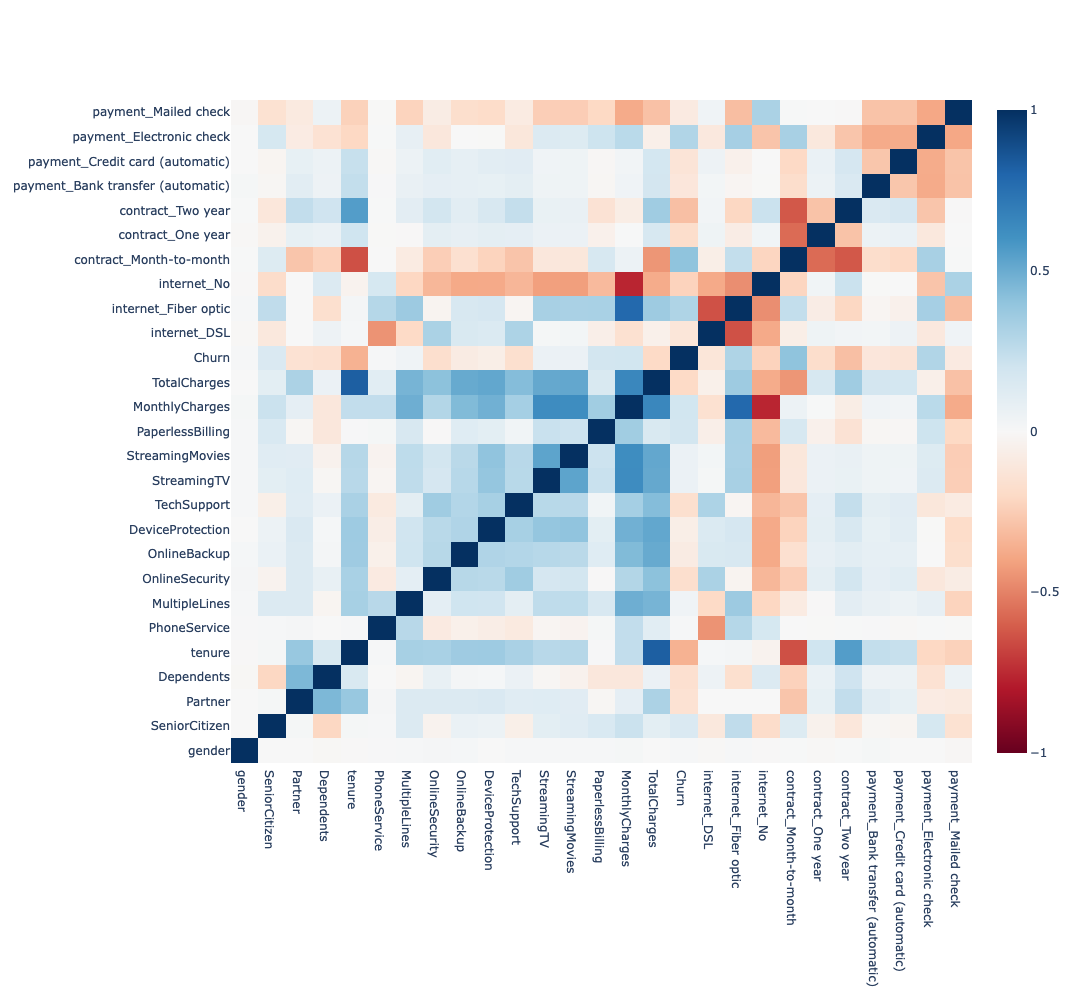

In [48]:
#Create correlation matrix
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

corrMatrix = dfNums.corr()

traceCorr = go.Heatmap(
    z=corrMatrix.values,
    x=corrMatrix.index.values,
    y=corrMatrix.columns.values,
    colorscale='RdBu',
    zmax=1,
    zmin=-1
)
figCorr = go.Figure()
figCorr.add_trace(traceCorr)
figCorr.layout.height = 1000
figCorr.show()

In [49]:
print(f"Insight 1: The 3 variables that have the highest correlation with churn are payment_Electronic check, contract_Month-to-month and internet_Fiber optic.")

Insight 1: The 3 variables that have the highest correlation with churn are payment_Electronic check, contract_Month-to-month and internet_Fiber optic.


> **Insight 2** | Create new dataframe dfGraph and checking churn by internet service option. Columns of DfGraph:
 
     -> categories of variables - "category"
     -> variables - "variables"
     -> customers churning and scoring 1 on each variable - "churnUsers"
     -> customers scoring 1 on each variable - "totalUsers"
     -> churn % per customer group scoring 1 on each variable - "%_Churn"
     -> % of customers scoring 1 on that variable - "%_Users"
     -> Average monthly charges of customers scoring 1 on each variable - "MonthlyCharges"

In [50]:
#Defining categories of variables
setup = ["PaperlessBilling","payment_Electronic check", "payment_Mailed check", "payment_Credit card (automatic)", "contract_Month-to-month", "contract_One year", "contract_Two year"]
product_internet = ["internet_DSL", "internet_Fiber optic", "StreamingTV", "StreamingMovies", "DeviceProtection", "OnlineBackup", "TechSupport","OnlineSecurity"]
product_phone = ["PhoneService", "MultipleLines", "internet_No"]
customer = ["SeniorCitizen", "gender", "Partner", "Dependents", "Churn"]

In [51]:
# Drop Non-Categorical Variables
dfGraph = dfNums.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])

# Use melt method to be able to groupby columns, "Churn" variable is taken out to be able to filter
dfMelted = dfNums.melt(id_vars=['Churn'], value_vars=list(dfGraph.columns))

# Get total number of users per variable using the sum method
dfUsers = dfMelted.groupby(by=['variable'], as_index=False)['value'].sum().rename({'value':'totalUsers'}, axis=1)

# Filter the Melted Df to get only churning users, then group by to get the total number of churning users per variable
dfUsersChurn = dfMelted.loc[dfMelted['Churn'] == 1, :]
dfUsersChurn = dfUsersChurn.groupby(by=['variable'], as_index=False)['value'].sum().rename({'value':'churnUsers'}, axis=1)

# Calculate average tenure for users within each Categorical Variable. Use melt method, then groupby for only those users in each category.
dfCharges = dfNums.melt(id_vars=['MonthlyCharges'], value_vars=list(dfGraph.columns))
dfCharges = dfCharges.loc[dfCharges['value'] == 1, :].groupby(by='variable',as_index=False)['MonthlyCharges'].mean()

# Merge series to get a dataframe: dfUsers + dfUsersChurn + dfTenure
dfGraph = pd.merge(dfUsers, dfUsersChurn, on='variable')
dfGraph = pd.merge(dfGraph, dfCharges, on='variable')

def categories(var):
    if var in setup:
        return "setup"
    if var in product_internet:
        return "product_internet"
    if var in product_phone:
        return "product_phone"
    return "customer"

# Categorize variables into categories by using 'categories' function
dfGraph['category'] = dfGraph['variable'].apply(lambda var: categories(var))

# Calculate %_Churn and %_Users for each of the variables
dfGraph['%_Churn'] = dfGraph.churnUsers/dfGraph.totalUsers
dfGraph['%_Users'] = dfGraph.totalUsers/len(df)

# Round to two decimals
dfGraph = dfGraph.round(2)

# Order columns for better visualization
dfGraph = dfGraph[['category','variable','churnUsers', 'totalUsers', '%_Churn', '%_Users', 'MonthlyCharges']]
# Sort by %_Churn
dfGraph.sort_values('%_Churn', ascending=False)

,category,variable,churnUsers,totalUsers,%_Churn,%_Users,MonthlyCharges
21,setup,payment_Electronic check,1071,2365,0.45,0.34,76.26
12,setup,contract_Month-to-month,1655,3875,0.43,0.55,66.40
8,customer,SeniorCitizen,476,1142,0.42,0.16,79.82
17,product_internet,internet_Fiber optic,1297,3096,0.42,0.44,91.50
5,setup,PaperlessBilling,1400,4171,0.34,0.59,73.55
9,product_internet,StreamingMovies,818,2732,0.30,0.39,88.48
10,product_internet,StreamingTV,814,2707,0.30,0.38,88.74
2,product_phone,MultipleLines,850,2971,0.29,0.42,82.04
15,customer,gender,939,3488,0.27,0.50,65.20
7,product_phone,PhoneService,1699,6361,0.27,0.90,67.20


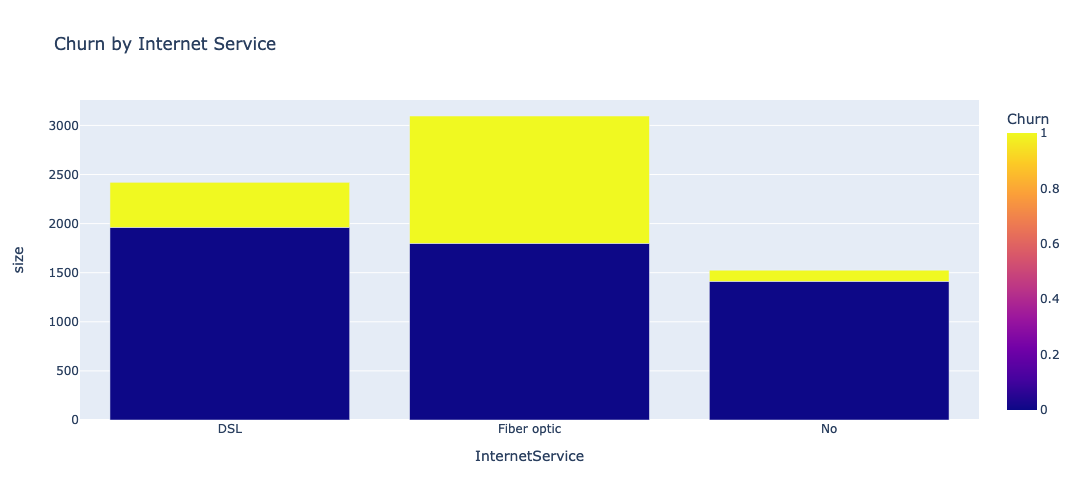

In [52]:
InternetDf = df[['InternetService','Churn']].groupby(by=['InternetService','Churn'], as_index=False).size()
fig = px.bar(InternetDf, x="InternetService", y="size", color="Churn", title="Churn by Internet Service",height=500)
fig.show()

In [53]:
print(f"Insight 2: Customers without internet tend to churn less (only {round(dfGraph[dfGraph.variable =='internet_No']['%_Churn'].values[0]*100,2)}% churn rate vs. {round(percentchurn,2)}% company average) while customer having the fiber tend to churn much more ({round(dfGraph[dfGraph.variable =='internet_Fiber optic']['%_Churn'].values[0]*100,2)}% churn rate)")

Insight 2: Customers without internet tend to churn less (only 7.0% churn rate vs. 26.54% company average) while customer having the fiber tend to churn much more (42.0% churn rate)


> **Insight 3** | Zooming into customers with internet service

In [54]:
sec = pd.pivot_table(df[df['InternetService'].isin(['DSL','Fiber optic'])][['OnlineSecurity','Churn']], index='OnlineSecurity', columns='Churn', aggfunc='size')
sec['% churn'] = round(sec[1]/(sec[0]+sec[1])*100,2)
sec

Churn,0,1,% churn
OnlineSecurity,,,
0,2037,1461,41.77
1,1724,295,14.61


In [55]:
tech = pd.pivot_table(df[df['InternetService'].isin(['DSL','Fiber optic'])][['TechSupport','Churn']], index='TechSupport', columns='Churn', aggfunc='size')
tech['% churn'] = round(tech[1]/(tech[0]+tech[1])*100,2)
tech

Churn,0,1,% churn
TechSupport,,,
0,2027,1446,41.64
1,1734,310,15.17


In [56]:
print(f"Insight 3: Customers with internet service ({round(dfGraph[dfGraph.variable =='internet_Fiber optic']['%_Users'].values[0]*100+dfGraph[dfGraph.variable =='internet_DSL']['%_Users'].values[0]*100,2)}% of all customers) tend to churn more if they do not have the tech support ({tech.loc[0,'% churn']}% churn rate) and/or the online security ({sec.loc[0,'% churn']}% churn rate).")

Insight 3: Customers with internet service (78.0% of all customers) tend to churn more if they do not have the tech support (41.64% churn rate) and/or the online security (41.77% churn rate).


> **Insights 4 & 5** | Analysing customer groups & churn

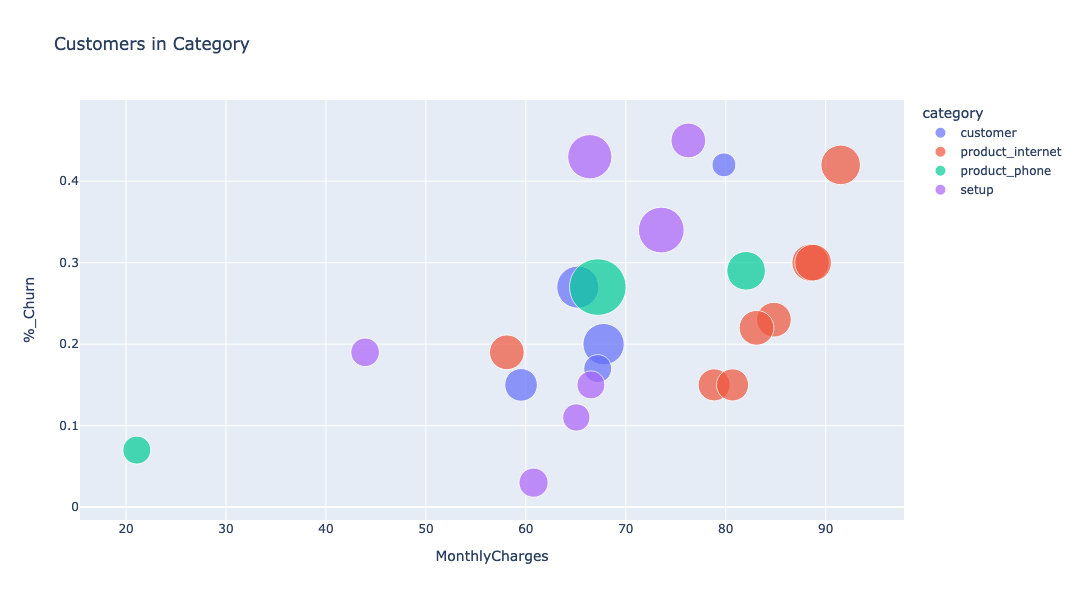

In [57]:
import plotly.express as px

fig = px.scatter(
    dfGraph, 
    x = "MonthlyCharges", 
    y = "%_Churn",
	size = "%_Users", 
    color = "category",
    hover_name = "variable",
    title = "Customers in Category", 
    size_max=40,
    height = 600)
    
fig.show()

In [58]:
print(f"Insight 4: Differences between churning and non-churning customers come from the time of contract customers have and the type of internet product they have. Demographics variables about the customer and type of phone product they have do not seem to play a role.")

Insight 4: Differences between churning and non-churning customers come from the time of contract customers have and the type of internet product they have. Demographics variables about the customer and type of phone product they have do not seem to play a role.


In [59]:
print(f"Insight 5: A very small proportion of customers have a one year ({round(dfGraph[dfGraph.variable =='contract_One year']['%_Users'].values[0]*100,2)}%) or two year contract ({round(dfGraph[dfGraph.variable =='contract_Two year']['%_Users'].values[0]*100,2)}%) while these feature seem to significantly bring down the churn rate while a high proportion of customers have a month to month contract ({round(dfGraph[dfGraph.variable =='contract_Month-to-month']['%_Users'].values[0]*100,2)}%).")

Insight 5: A very small proportion of customers have a one year (21.0%) or two year contract (24.0%) while these feature seem to significantly bring down the churn rate while a high proportion of customers have a month to month contract (55.0%).
